In [29]:
import pandas
dfMistral = pandas.read_json("./mistral_inference.jsonl",lines=True)
dfMamba = pandas.read_csv("./mambaChat_inference_nums_0-2400.csv")

In [30]:
import sys
import json
import re
import string
from collections import Counter
import pickle

In [31]:
def normalize_answer(s):

    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

In [32]:
def f1_score(prediction, ground_truth):
    normalized_prediction = normalize_answer(prediction)
    normalized_ground_truth = normalize_answer(ground_truth)

    ZERO_METRIC = (0, 0, 0)

    if normalized_prediction in ['yes', 'no', 'noanswer'] and normalized_prediction != normalized_ground_truth:
        return ZERO_METRIC
    if normalized_ground_truth in ['yes', 'no', 'noanswer'] and normalized_prediction != normalized_ground_truth:
        return ZERO_METRIC

    prediction_tokens = normalized_prediction.split()
    ground_truth_tokens = normalized_ground_truth.split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return ZERO_METRIC
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1, precision, recall

In [33]:
def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))

In [34]:
def update_answer(metrics, prediction, gold):
    em = exact_match_score(prediction, gold)
    f1, prec, recall = f1_score(prediction, gold)
    metrics['em'] += float(em)
    metrics['f1'] += f1
    metrics['prec'] += prec
    metrics['recall'] += recall
    return em,f1, prec, recall

In [35]:
def generate_metrics(df,predColumnName):
    metrics = {'em': 0, 'f1': 0, 'prec': 0, 'recall': 0}
    outArray = []
    for i in range(len(df)): #len(df)
        gold = df.loc[i,"goldenResponse"]
        pred = df.loc[i,predColumnName]
        em,f1, prec, recall = update_answer(metrics,pred,gold)
        outArray.append([em,f1,prec,recall])

    N = len(df)
    for k in metrics.keys():
        metrics[k] /= N

    return metrics, outArray

In [36]:
metricsMistral,outArrayMistral = generate_metrics(dfMistral,"raw_output")
metricsMamba, outArrayMamba = generate_metrics(dfMamba,"modelOutput")
metricsMistral,metricsMamba

({'em': 0.06961233847436432,
  'f1': 0.5356865131693366,
  'prec': 0.45275982405269644,
  'recall': 0.8106929998123262},
 {'em': 0.025844101709045435,
  'f1': 0.3463874515165864,
  'prec': 0.39122511422961354,
  'recall': 0.5128737009154081})

In [37]:
output = []
for i in range(len(outArrayMistral)):
    if outArrayMistral[i][1]<outArrayMamba[i][1] and outArrayMistral[i][2]<outArrayMamba[i][2] and outArrayMistral[i][3]<outArrayMamba[i][3]:
        output.append([i,dfMistral.loc[i,"goldenResponse"],dfMistral.loc[i,"raw_output"],dfMamba.loc[i,"modelOutput"]])
output

[[17,
  'The keynote address was delivered by Margaret Ezell from Texas A&M University.',
  ' Margaret Ezell delivered the keynote address at the University of California, Santa Barbara event on April 24, 2015.',
  'The keynote address was given by Margaret Ezell, Texas A&M University.'],
 [52,
  "The Na 'Aina Kai Botanical Garden is described as a true magical paradise where you can experience the many moods and diversity of its beauty.",
  " The Na 'Aina Kai Botanical Garden is described as a magical paradise where one can experience the various moods and diversity of its beauty. It is not specified what type of garden it is or what stylistic genres are present, but it is noted that it has not yet produced flowers, despite having the potential to attract more butterflies and various species with the emergence of blooms. Additionally, no mention is made of any specific methods used to keep pests away or encourage beneficial insects, unlike other gardens mentioned in the context.",
  "

In [38]:
# bigMetrics = metricsMistral
# for i in bigMetrics.keys():
#     bigMetrics[i] = [metricsMistral[i],metricsMamba[i]]
# bigMetrics



listMistral = []
for i in metricsMistral.keys():
    listMistral.append(round(metricsMistral[i],3))
listMistral

listMamba = []
for i in metricsMamba.keys():
    listMamba.append(round(metricsMamba[i],3))
listMamba

bigDict = {"Mistral-7b":listMistral,"MambaChat_NoRobots-2B":listMamba}

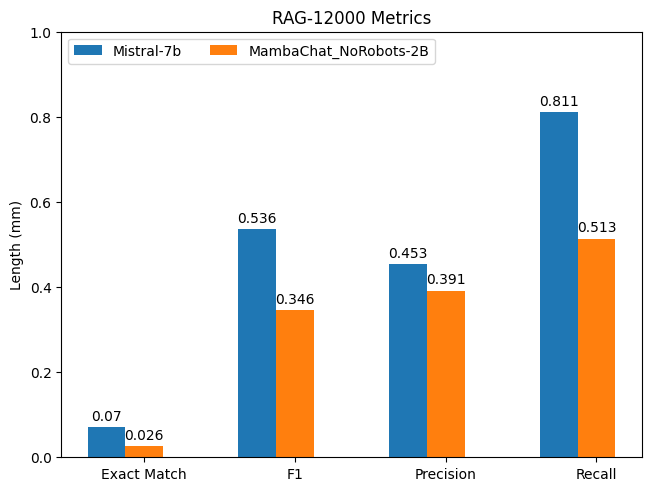

In [40]:
import matplotlib.pyplot as plt
import numpy as np

labels = ("Exact Match","F1","Precision","Recall")

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in bigDict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('RAG-12000 Metrics')
ax.set_xticks(x + width, labels)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 1)

# plt.show()
plt.savefig("./pic.png")